**(Dynamic) Thompson Sampling, as described in Gupta et al. - 2011 - Thompson sampling for dynamic multi-armed bandits**

> Thompson sampling is a probabilistic approach to solve the Multi-Armed Bandit. This paper modifies the original algorithm to make it handle distribution changes during the execution

The Thompson Sampling in this paper considers that each arm is a Bernoulli trial, having the output set ${0, 1}$, with $\theta^k$ denoting the probability of success for arm $k$.

The probability distribution of successes $S$ obtained in $n^k$ trials is a Binomial distribution:

$$p(S = s|\theta^k) = \binom{n^k}{s} (1-\theta^k)^{n-s}(\theta^k)^s.$$

The Beta distribution is a conjugate prior (is of the same probability distribution family as the prior probability, which is the Binomial distribution), parameterized by $\alpha_0$ and $\beta_0$:

$$p(\widehat{\theta}^k; \alpha_0, \beta_0) = \frac{x^{\alpha_0-1}(1-x)^{\beta_0-1}}{B(\alpha_0, \beta_0)},$$

with $B$ being a binonial distribution.

> We use conjugate prior to derive a closed-form expression for the posterior distribution, usually easier to interpret, manipulate and update. In Bayesian statistics, we adjust the hyperparameters of the posterior distribution to optimize the likelihood with the prior distribution.

The **original Thompson sampling** updates $\alpha_n$ and $\beta_n$ for the $n$-th trial, with reward $r_n$ as:

$$\alpha^k_ n = \alpha^k_{n-1} + r_n,$$
$$\beta^k_ n = \beta^k_{n-1} + (1-r_n).$$

The proposed method extends the original algorithm by inserting a new update rule based on an hyperparameter $C$. $C$ is a threshold that provides exponential weighting of the outcomes of the trials, making more recent rewards getting more weight. This way, if prior distributions change during the execution, the learned posterior distributions would respond to it.

We update $\alpha_n$ and $\beta_n$ conditionally based on $C$:

If $\alpha_{n-1}+\beta_{n-1}<C$, we use the original Thompson Sampling. Otherwise, we update

$$\alpha^k_ n = (\alpha^k_{n-1} + r_n)\frac{C}{C+1},$$
$$\beta^k_ n = (\beta^k_{n-1} + (1-r_n))\frac{C}{C+1}.$$

> The paper suggest initializing all $\alpha$ and $\beta$ with the value $2$ for all arms.

The remaining of the paper performs an sensitivity analysis and some experiments to check how well the Dynamic Thompson Sampling performs.

> In our work, the mutations would be the arms, and this update would be used during the evolution to adjust the mutation probabilities.

> Brush originally sample the mutations using an uniform distribution. This algorithm learns hyperparameters to Beta distributions. Somehow we need to convert them to have a transparent implementation to the user.


In [1]:
import numpy as np

# TODO: Maybe I could create a base class to be inherited by different learners
class D_TS:
    def __init__(self, num_bandits, C=100):
        self.num_bandits = num_bandits

        # Store tuples when update is called. Tuples will have 3 values:
        # (time instant t, arm idx, reward)
        self.pull_history = [] 

        # This is the probability that should be used to update brush probs
        self._probabilities = np.ones(num_bandits)/num_bandits

        self._alphas = 2*np.ones(num_bandits) # Paper suggests starting with 2's
        self._betas  = 2*np.ones(num_bandits)
        self.C       = C # how to define this value???

    @property
    def probabilities(self):
        # How to transform our Beta distributions into node probabilities?
        return self._probabilities
    
    @probabilities.setter
    def probabilities(self, new_probabilities):
        if len(self._probabilities)==len(new_probabilities):
            self._probabilities = new_probabilities
        else:
            print(f"New probabilities must have size {self.num_bandits}")

    def choose_arm(self):
        """Uses the learned distributions to randomly choose an arm to pull. 
        
        Returns the index of the arm that was choosen based on the Beta
        probabilities of previous successes and fails.
        """
        
        # probability estimates from the beta distribution
        thetas = np.random.beta(self._alphas, self._betas)
        
        arm_idx = np.argmax(thetas)
        
        return arm_idx
    
    def update(self, arm_idx, reward):
        self.pull_history.append( (len(self.pull_history), arm_idx, reward) )

        if self._alphas[arm_idx] + self._betas[arm_idx] < self.C:
            # This is the pure thompson scheme
            self._alphas[arm_idx] = self._alphas[arm_idx]+reward
            self._betas[arm_idx]  = self._betas[arm_idx] + (1-reward)
        else:
            # This is the dynamic adjust
            self._alphas[arm_idx] = (self._alphas[arm_idx]+reward)*(self.C/(self.C+1))
            self._betas[arm_idx]  = (self._betas[arm_idx] + (1-reward))*(self.C/(self.C+1))

        return self

In [2]:
# Sanity checks

class Bandits:
    def __init__(self, reward_prob):
        # Implementing simple bandits.
        self.reward_prob = reward_prob # True reward prob., which learner shoudn't know
        self.n_bandits   = len(reward_prob) 

    def pull(self, arm_idx):
        # Sampling over a normal distr. with mu=0 and var=1
        result = np.random.randn()
        
        # return a positive or nullary reward (Bernoulli random variable).
        return 1.0 if result > self.reward_prob[arm_idx] else 0.0

for probs, descr, expec in [
    (np.array([ 1.0,  1.0, 1.0,  1.0]), 'All bandits with same probs'  , 'similar amount of pulls for each arm'         ),
    (np.array([-1.0,  0.2, 0.0,  1.0]), 'One bandit with higher prob'  , 'more pulls for first arm, less pulls for last'),
    (np.array([-0.2, -1.0, 0.0, -1.0]), 'Two bandits with higher probs', '2nd approx 4th > 1st > 3rd'                   ),
]:
    bandits = Bandits(probs)

    print("------------------------ optimizing ------------------------")

    learner = D_TS(4)
    for i in range(1000):
        arm_idx = learner.choose_arm()
        reward  = bandits.pull(arm_idx)

        learner.update(arm_idx, reward) 

    total_rewards = {arm_idx : sum([r for (t, i, r) in learner.pull_history if i==arm_idx])
                     for arm_idx in range(learner.num_bandits)}

    total_pulls   = {arm_idx : sum([1 for (t, i, r) in learner.pull_history if i==arm_idx])
                     for arm_idx in range(learner.num_bandits)}

    print("cum. reward for each arm    : ", total_rewards)
    print("number of pulls for each arm: ", total_pulls)
    print(f"(it was expected: {expec})")

------------------------ optimizing ------------------------
cum. reward for each arm    :  {0: 10.0, 1: 46.0, 2: 46.0, 3: 54.0}
number of pulls for each arm:  {0: 94, 1: 298, 2: 305, 3: 303}
(it was expected: similar amount of pulls for each arm)
------------------------ optimizing ------------------------
cum. reward for each arm    :  {0: 812.0, 1: 2.0, 2: 3.0, 3: 1.0}
number of pulls for each arm:  {0: 977, 1: 9, 2: 9, 3: 5}
(it was expected: more pulls for first arm, less pulls for last)
------------------------ optimizing ------------------------
cum. reward for each arm    :  {0: 4.0, 1: 318.0, 2: 2.0, 3: 543.0}
number of pulls for each arm:  {0: 8, 1: 364, 2: 5, 3: 623}
(it was expected: 2nd approx 4th > 1st > 3rd)


In [3]:
from brush.estimator import BrushEstimator
from sklearn.base import ClassifierMixin, RegressorMixin
from deap import creator
import _brush
from deap_api import nsga2 

class BrushEstimatorMod(BrushEstimator): # Modifying brush estimator
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def _mutate(self, ind1):
        # Overriding the mutation so it updates our sampling method. Doing the
        # logic on the python-side for now.

        # Creating a wrapper for mutation to be able to control what is happening
        # in the C++ code (this should be prettier in a future implementation)
        mutations = ['point', 'insert', 'delete', 'toggle_weight']
        params = self.get_params()
        
        ignore_this_time = True if (ind1.prg.size()+1>=self.max_size
                                    or ind1.prg.depth()+1>=self.max_depth) else False

        # Insert Mutation will not work, even if we force it, when the expression
        # is already at maximum size.
        # In this case, we'll do the mutation without controlling the probabilities.
        if ignore_this_time:
            for i, m in enumerate(mutations):
                params['mutation_options'][m] = 0.25 # let cpp do the mutation 
        else:
            mutation_idx = self.learner_.choose_arm()

            for i, m in enumerate(mutations):
                params['mutation_options'][m] = 0 if i != mutation_idx else 1.0

        _brush.set_params(params)
    
        # ind1.prg.mutate is a convenient interface that uses the current search 
        # space to sample mutations
        offspring = creator.Individual(ind1.prg.mutate())

        offspring.fitness.values = self.toolbox_.evaluate(offspring)
        
        # We compare fitnesses using the deap overloaded operators
        # from the docs: When comparing fitness values that are **minimized**,
        # ``a > b`` will return :data:`True` if *a* is **smaller** than *b*.
        # (this means that this comparison should work agnostic of min/max problems,
        # or even a single-objective or multi-objective problem)
        reward = 1.0 if offspring.fitness > ind1.fitness else 0.0
        
        if not ignore_this_time:
            self.learner_.update(mutation_idx, reward)
        
        return offspring
    
    def fit(self, X, y):

        _brush.set_params(self.get_params())

        self.data_ = self._make_data(X,y)
        # self.data_.print()

        # set n classes if relevant
        if self.mode=="classification":
            self.n_classes_ = len(np.unique(y))

        # We have 4 different mutations, and the learner will learn to choose
        # between these options by maximizing the reward when using each one
        self.learner_ = D_TS(4)

        if isinstance(self.functions, list):
            self.functions_ = {k:1.0 for k in self.functions}
        else:
            self.functions_ = self.functions

        self.search_space_ = _brush.SearchSpace(self.data_, self.functions_)

        self.toolbox_ = self._setup_toolbox(data=self.data_)

        archive, logbook = nsga2(
            self.toolbox_, self.max_gen, self.pop_size, 0.9, self.verbosity)

        self.archive_ = archive
        self.best_estimator_ = self.archive_[0].prg

        return self
    

class BrushClassifierMod(BrushEstimatorMod,ClassifierMixin):
    def __init__( self, **kwargs):
        super().__init__(mode='classification',**kwargs)

    def _fitness_function(self, ind, data: _brush.Dataset):
        ind.prg.fit(data)
        return (
            np.abs(data.y-ind.prg.predict(data)).sum(), 
            ind.prg.size()
        )
    
    def _make_individual(self):
        return creator.Individual(
            self.search_space_.make_classifier(self.max_depth, self.max_size)
            if self.n_classes_ == 2 else
            self.search_space_.make_multiclass_classifier(self.max_depth, self.max_size)
            )

    def predict_proba(self, X):
        data = self._make_data(X)
        return self.best_estimator_.predict_proba(data)


class BrushRegressorMod(BrushEstimatorMod, RegressorMixin):
    def __init__(self, **kwargs):
        super().__init__(mode='regressor',**kwargs)

    def _fitness_function(self, ind, data: _brush.Dataset):
        ind.prg.fit(data)
        return (
            np.sum((data.y- ind.prg.predict(data))**2),
            ind.prg.size()
        )

    def _make_individual(self):
        return creator.Individual(
            self.search_space_.make_regressor(self.max_depth, self.max_size)
        )

## Regression problem

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 
gen	evals	ave            	std                    	min      
0  	200  	[   nan 20.715]	[       nan 0.85074967]	[nan 20.]
1  	200  	[   nan 11.905]	[       nan 7.09408028]	[nan  1.]
2  	200  	[  nan 2.655]  	[       nan 2.14615354]	[nan  1.]
3  	200  	[5.25970482 1.03      ]	[1.21317177 0.17058722]	[2.73836112 1.        ]
4  	200  	[4.47344586 1.02      ]	[1.05184037 0.14      ]	[2.73836112 1.        ]
5  	200  	[3.86163747 1.01      ]	[0.11289352 0.09949874]	[2.73836112 1.        ]
6  	200  	[3.86163747 1.01      ]	[0.11289352 0.09949874]	[2.73836112 1.        ]
7  	200  	[3.86163747 1.01      ]	[0.11289352 0.09949874]	[2.73836112 1.        ]
8  	200  	[3.86163747 1.01      ]	[0.11289352 0.09949874]	[2.73836112 1.        ]
9  	200  	[3.86163747 1.01      ]	[0.11289352 0.09949874]	[2.73836112 1.        ]
10 	200  	[3.86163747 1.01      ]	[0.11289352 0.09949874]	[2.73836112 1.   

Brush version  Original                                     Modified   
metric            score                         best model     score   
run 0          0.326358                  1.04*Cos(1.73*x2)  0.533820  \
run 1          0.326358                  1.04*Cos(1.73*x2)  0.377649   
run 2          0.338504                 0.01*Cosh(5.22*x1)  0.326358   
run 3          0.325058                       Cos(1.72*x2)  0.454707   
run 4          0.338883                 0.02*Cosh(5.01*x1)  0.367291   
run 5          0.325058                      Cos(-1.72*x2)  0.366009   
run 6          0.326358                 1.04*Cos(-1.73*x2)  0.362638   
run 7          0.397507               Square(Sin(4.25*x2))  0.363372   
run 8          0.292958                    Square(0.96*x1)  0.326358   
run 9          0.350809           If(x1>0.91,5.00*x2,0.38)  0.551571   
run 10         0.431209  Logistic(156.42*Logabs(-1.12*x1))  0.473042   
run 11         0.325058                       Cos(1.72*x2)  0.326358   
run 12         0.314972                 0.51*Acos(1.10*x2)  0.326358   
run 13         0.397507              Square(Sin(-4.25*x2))  0.363372   
run 14         0.397507              Square(Sin(-4.25*x2))  0.508543   
run 15         0.397507               Square(Sin(4.25*x2))  0.363372   
run 16         0.363372       If(x1>0.91,5.00*x2,-0.52*x1)  0.972920   
run 17         0.397507               Square(Sin(4.25*x2))  0.675277   
run 18         0.397507               Square(Sin(4.25*x2))  0.326358   
run 19         0.325058                       Cos(1.72*x2)  0.670912   
run 20         0.397507              Square(Sin(-4.25*x2))  0.363372   
run 21         0.314972                 0.51*Acos(1.10*x2)  0.326358   
run 22         0.397507               Square(Sin(4.25*x2))  0.350809   
run 23         0.397507               Square(Sin(4.25*x2))  0.363372   
run 24         0.397507               Square(Sin(4.25*x2))  0.326358   
run 25         0.198205                       Abs(0.74*x1)  0.363372   
run 26         0.397507              Square(Sin(-4.25*x2))  0.742135   
run 27         0.326358                  1.04*Cos(1.73*x2)  0.999129   
run 28         0.292958                    Square(0.96*x1)  0.350809   
run 29         0.292958                    Square(0.96*x1)  0.326358   

Brush version                                                      
metric                                                best model   
run 0                    0.99*Median(2.01,1.24,-2.40*x2,1.25*x1)  \
run 1                        0.49*Tan(If(x1>0.91,4.41,-0.83*x1))   
run 2                                          1.04*Cos(1.73*x2)   
run 3                Abs(Median(If(x1>0.91,3.06,-1.00*x1),0.16))   
run 4                       1.04*Cos(Mean(2.51*x2,0.83,1.78*x2))   
run 5          Mean(3.98*Cos(1.36*x2),-0.67*x2,0.22*x1,-0.66*x2)   
run 6                            Sum(0.98*Cos(1.36*x2),-0.36*x2)   
run 7                                  If(x1>0.91,1.61,-0.52*x1)   
run 8                                          1.04*Cos(1.73*x2)   
run 9                              Logistic(218.18*Cos(3.35*x2))   
run 10                         Logabs(If(x1>0.91,5.00,-2.10*x1))   
run 11                                         1.04*Cos(1.73*x2)   
run 12                                         1.04*Cos(1.73*x2)   
run 13                                 If(x1>0.91,1.61,-0.52*x1)   
run 14                        Median(2.01,1.27*x1,1.27,-1.94*x2)   
run 15                                 If(x1>0.91,1.61,-0.52*x1)   
run 16         If(x1>0.91,1.61,Median(2.00*x1,-3.75*x2,-2.11*...   
run 17          Sum(Median(1.20,1.38,-2.49*x2,2.80*x1),-0.33*x1)   
run 18                                         1.04*Cos(1.73*x2)   
run 19         Mean(Median(2.85,4.99*x1,-4.75*x2,2.29),-0.86*x1)   
run 20                                 If(x1>0.91,1.61,-0.52*x1)   
run 21                                         1.04*Cos(1.73*x2)   
run 22                                     If(x1>0.91,1.61,0.38

Brush version   Original   Modified                        
metric             score      score point mutation calls   
count          30.000000  30.000000            30.000000  \
mean            0.350268   0.451612          1249.633333   
std             0.049770   0.185220           560.844098   
min             0.198205   0.326358           197.000000   
25%             0.325058   0.332471           804.500000   
50%             0.338693   0.363372          1202.500000   
75%             0.397507   0.499668          1574.500000   
max             0.431209   0.999129          2418.000000   

Brush version                                               
metric        insert mutation calls delete mutation calls   
count                     30.000000             30.000000  \
mean                    3672.300000           1403.633333   
std                      762.725609            560.789621   
min                     2265.000000            568.000000   
25%                     3185.250000            996.500000   
50%                     3835.500000           1361.000000   
75%                     4222.000000           1838.750000   
max                     5667.000000           2575.000000   

Brush version                               
metric        toggle_weight mutation calls  
count                            30.000000  
mean                           1311.233333  
std                             598.792963  
min                             142.000000  
25%                             998.000000  
50%                            1375.000000  
75%                            1631.000000  
max                            2987.000000

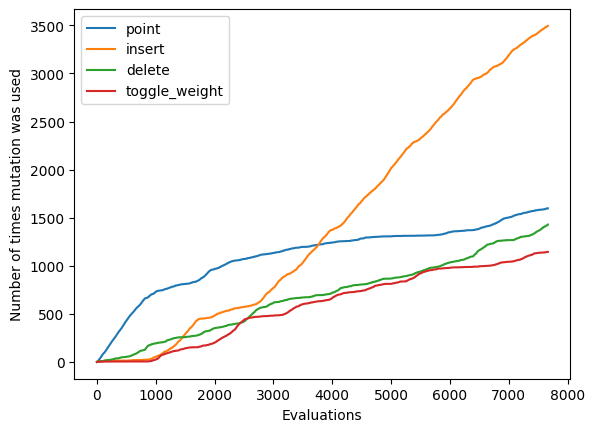

In [4]:
# This is needed to avoid racing conditions (https://deap.readthedocs.io/en/master/tutorials/basic/part4.html)
if __name__ == '__main__':
    import pandas as pd
    from brush import BrushRegressor
    
    import warnings
    warnings.filterwarnings("ignore")

    # data = pd.read_csv('../../docs/examples/datasets/d_enc.csv')
    # X = data.drop(columns='label')
    # y = data['label']

    # data = pd.read_csv('../../docs/examples/datasets/d_2x1_subtract_3x2.csv')
    # X = data.drop(columns='target')
    # y = data['target']

    data = pd.read_csv('../../docs/examples/datasets/d_square_x1_plus_2_x1_x2_plus_square_x2.csv')
    X = data.drop(columns='target')
    y = data['target']

    kwargs = {
        'pop_size'  : 200,
        'max_gen'   : 40,
        'max_depth' : 10,
        'max_size'  : 20,
        'mutation_options' : {"point":0.25, "insert": 0.25, "delete":  0.25, "toggle_weight": 0.25}
    }

    df = pd.DataFrame(columns=pd.MultiIndex.from_tuples(
        [('Original', 'score'), ('Original', 'best model'), 
         ('Modified', 'score'), ('Modified', 'best model'), 
         ('Modified', 'point mutation calls'),
         ('Modified', 'insert mutation calls'),
         ('Modified', 'delete mutation calls'),
         ('Modified', 'toggle_weight mutation calls')],
        names=('Brush version', 'metric')))
    
    est_mab = None
    for i in range(30):
        try:
            print(f"{i}, ", end='\n' if (i==29) else '')
            kwargs['verbosity'] = (i==29) #verbosity only on last one

            est     = BrushRegressor(**kwargs).fit(X,y)
            est_mab = BrushRegressorMod(**kwargs).fit(X,y)

            total_rewards = {arm_idx : sum([r for (t, i, r) in est_mab.learner_.pull_history if i==arm_idx])
                            for arm_idx in range(est_mab.learner_.num_bandits)}
            total_pulls   = {arm_idx : sum([1 for (t, i, r) in est_mab.learner_.pull_history if i==arm_idx])
                            for arm_idx in range(est_mab.learner_.num_bandits)}
            
            df.loc[f'run {i}'] = [est.score(X,y), est.best_estimator_.get_model(),
                                est_mab.score(X,y), est_mab.best_estimator_.get_model(), *total_pulls.values()]
        except Exception as e:
            print(e)

    display(df)
    display(df.describe())

    if True: # plot the cumulative history of pulls
        !pip install matplotlib > /dev/null
        import matplotlib.pyplot as plt

        # Plot for evaluations, not generations
        data = np.zeros( (len(est_mab.learner_.pull_history)+1, 4) )
        for i, (t, arm, r) in enumerate(est_mab.learner_.pull_history):
            data[i+1, :] = data[i]
            data[i+1, arm] += 1
            
        plt.plot(data, label=['point', 'insert', 'delete', 'toggle_weight'])
        plt.xlabel("Evaluations")
        plt.ylabel("Number of times mutation was used")
        plt.legend()

## Classification problem

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 
gen	evals	ave          	std                    	min      
0  	200  	[24.94 20.7 ]	[0.84047606 1.05356538]	[19. 14.]
1  	200  	[24.58  16.665]	[1.44346805 5.34441531]	[12.  2.]
2  	200  	[24.215 10.995]	[1.92321996 6.51037441]	[12.  2.]
3  	200  	[23.785  6.02 ]	[2.59784045 5.73756046]	[12.  2.]
4  	200  	[23.49   3.855]	[3.04136483 4.1765985 ]	[12.  2.]
5  	200  	[24.655  2.235]	[1.79331397 1.43170353]	[12.  2.]
6  	200  	[24.605  2.275]	[1.91806543 1.53276711]	[12.  2.]
7  	200  	[24.56  2.31]  	[2.01156655 1.60433787]	[12.  2.]
8  	200  	[24.725  2.15 ]	[1.52294944 0.94207218]	[12.  2.]
9  	200  	[24.725  2.15 ]	[1.52294944 0.94207218]	[12.  2.]
10 	200  	[24.725  2.15 ]	[1.52294944 0.94207218]	[12.  2.]
11 	200  	[24.725  2.125]	[1.66414392 0.87142125]	[12.  2.]
12 	200  	[24.675  2.145]	[1.79982638 0.91322232]	[12.  2.]
13 	200  	[24.65   2.155]	[1.88613361 0.93326041]	[12

Brush version Original                                                      
metric           score                                         best model   
run 0             0.68                                    Sqrt(0.00*AIDS)  \
run 1             0.82  Abs(Sinh(Log1p(Min(Median(0.01*AIDS,Total),Div...   
run 2             0.68  Logistic(Add(Ceil(Sqrtabs(Prod(6.09*AIDS,-0.00...   
run 3             0.82  Logistic(Min(Sum(0.01*AIDS,-0.72,-0.72),2.30,D...   
run 4             0.78  Logistic(Min(Cos(Sub(Mean(If(AIDS>68817.00,Tan...   
run 5             0.86  Sum(Sin(-0.48*AIDS),Abs(Sin(-0.49*AIDS)),-5.57...   
run 6             0.88  Median(Sqrt(Tan(Atan(Cos(Sum(0.48*AIDS,0.92)))...   
run 7             0.88  Mean(Sin(Mean(1.00*Total,1.00*Total,1.00*Total...   
run 8             0.84  Add(Sum(Sub(Max(Cos(Sum(Median(1.00*Total,Sqrt...   
run 9             0.78  Div(Sum(Cos(2.88*Total),Mean(Logabs(133518.33*...   
run 10            0.82  Mean(Exp(Sin(Sum(0.00*AIDS,1.09,Total))),0.00*...   
run 11            0.80  Sqrt(Log1p(Max(0.00*AIDS,Sub(Sub(Median(Total,...   
run 12            0.84  Add(Cos(Add(Cos(Mul(-1.21,Tan(Mean(-0.00*Total...   
run 13            0.80  Median(Pow(Cos(Sqrtabs(0.87*AIDS)),6.44),0.00*...   
run 14            0.70  Logistic(Sin(Add(Max(1.00*Total,1.00,1.00,1.00...   
run 15            0.84  Median(Mean(Sum(Sin(Tan(1.00*AIDS)),0.72,0.72,...   
run 16            0.78        Mean(Atan(0.19*AIDS),-0.00*Total,0.00*AIDS)   
run 17            0.72  Logistic(1.00*Sum(Mean(393.50,Total,393.43,1.0...   
run 18            0.72       Logistic(Sin(Div(Tan(1.00*AIDS),1.85*AIDS)))   
run 19            0.80  Mean(Cos(Sqrtabs(Median(1.00,1.09*AIDS,Median(...   
run 20            0.76  Logistic(Sub(0.82*Logabs(2.64*Median(1.50*Sum(...   
run 21            0.78      Atan(Atan(Sinh(Div(116.98*AIDS,0.14*Total))))   
run 22            0.84  Mean(Cos(Abs(0.67*AIDS)),Tanh(0.00*AIDS),Mean(...   
run 23            0.78  Logistic(Tan(Sum(1.05*Mul(1.12*Div(-390.05*AID...   
run 24            0.84  Abs(Sub(Abs(Max(Sin(Sum(0.00*Total,1.00*AIDS,1...   
run 25            0.86  Sqrtabs(Sinh(Ceil(Cos(Mean(0.64*AIDS,1.00*Tota...   
run 26            0.80  Logistic(Sin(Mean(Log(Total),1.29,Mean(0.94*Lo...   
run 27            0.68                 Median(Total,0.00*AIDS,-3.57,0.79)   
run 28            0.82  Max(Tanh(0.00*AIDS),Asin(Mean(Square(Sin(Media...   
run 29            0.78  Logistic(1.78*Sin(Sum(Pow(1.00*AIDS,1.00),AIDS...   

Brush version Modified                                                      
metric           score                                         best model   
run 0             0.76  Median(0.00*AIDS,Square(0.00*AIDS),3.97*Tan(1....  \
run 1             0.78    Logistic(1.01*Mean(-0.00*Total,0.02*AIDS,0.48))   
run 2             0.72        Logistic(Tan(1.32*Logabs(Sqrt(0.01*AIDS))))   
run 3             0.78  Logistic(Div(-0.57*Total,Mean(546.40*AIDS,1.27...   
run 4             0.86  Logistic(Atan(Cos(1.00*Mean(4.94,0.64*AIDS,Tot...   
run 5             0.68                                    Atan(0.00*AIDS)   
run 6             0.86  Median(2.06*Sum(-0.00*AIDS,Tan(1.00*AIDS)),0.8...   
run 7             0.74  Logistic(Sum(1.00*Sum(242.90,Total),3.38*AIDS,...   
run 8             0.68                                    Atan(0.00*AIDS)   
run 9             0.68                                    Tanh(0.00*AIDS)   
run 10            0.76  Logistic(Sum(-0.47*Total,726.97*AIDS,AIDS,3499...   
run 11            0.68                                 Sqrtabs(0.00*AIDS)   
run 12            0.78  Logistic(2.08*Sin(Median(1.00*Sub(1.00*AIDS,-1...   
run 13            0.76  Sqrt(0.06*Mean(Square(-0.13*AIDS),-0.30*Total,...   
run 14            0.68                                    Atan(0.00*AIDS)   
run 15            0.68                                    Sqrt(0.00*AIDS)   
run 16            0.78  Logistic(Mean(1.33*Sqrt(Div(1.44*Max(-2.70*Tot...   
run 17            0.68                                 Sqrtabs(0.00*AIDS

Brush version   Original   Modified                        
metric             score      score point mutation calls   
count          30.000000  30.000000            30.000000  \
mean            0.792667   0.740667          1161.600000   
std             0.058128   0.051323           590.924617   
min             0.680000   0.680000           114.000000   
25%             0.780000   0.680000           872.000000   
50%             0.800000   0.740000          1150.000000   
75%             0.840000   0.780000          1550.750000   
max             0.880000   0.860000          2551.000000   

Brush version                                               
metric        insert mutation calls delete mutation calls   
count                     30.000000             30.000000  \
mean                    3705.233333           1526.033333   
std                      924.765532            551.106003   
min                      760.000000            522.000000   
25%                     3375.250000           1176.750000   
50%                     3590.500000           1447.500000   
75%                     4093.250000           1850.000000   
max                     5595.000000           3123.000000   

Brush version                               
metric        toggle_weight mutation calls  
count                            30.000000  
mean                           1179.600000  
std                             633.857082  
min                              21.000000  
25%                             750.250000  
50%                            1174.000000  
75%                            1629.000000  
max                            2561.000000

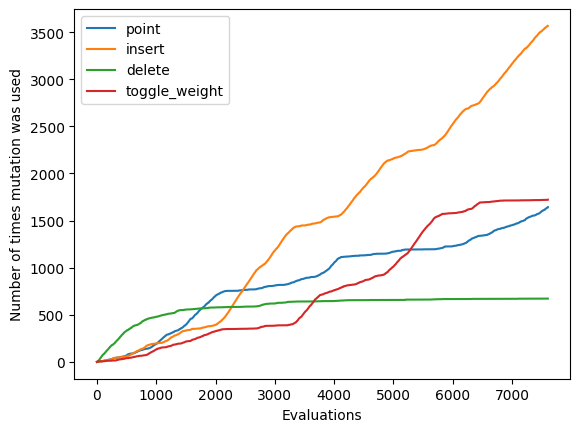

In [5]:
if __name__ == '__main__':
    import pandas as pd
    from brush import BrushClassifier
    
    import warnings
    warnings.filterwarnings("ignore")

    from pmlb import fetch_data

    # X, y = fetch_data('adult', return_X_y=True, local_cache_dir='./')

    data = pd.read_csv('../../docs/examples/datasets/d_analcatdata_aids.csv')
    X = data.drop(columns='target')
    y = data['target']

    kwargs = {
        'pop_size'  : 200,
        'max_gen'   : 40,
        'max_depth' : 10,
        'max_size'  : 20,
        'mutation_options' : {"point":0.25, "insert": 0.25, "delete":  0.25, "toggle_weight": 0.25}
    }

    df = pd.DataFrame(columns=pd.MultiIndex.from_tuples(
        [('Original', 'score'), ('Original', 'best model'), 
        ('Modified', 'score'), ('Modified', 'best model'), 
        ('Modified', 'point mutation calls'),
        ('Modified', 'insert mutation calls'),
        ('Modified', 'delete mutation calls'),
        ('Modified', 'toggle_weight mutation calls')],
        names=('Brush version', 'metric')))
    
    est_mab = None
    for i in range(30):
        try:
            print(f"{i}, ", end='\n' if (i==29) else '')
            kwargs['verbosity'] = (i==29) #verbosity only on last one

            est = BrushClassifier(**kwargs).fit(X,y)

            est_mab = BrushClassifierMod(**kwargs).fit(X,y)

            total_rewards = {arm_idx : sum([r for (t, i, r) in est_mab.learner_.pull_history if i==arm_idx])
                            for arm_idx in range(est_mab.learner_.num_bandits)}
            total_pulls   = {arm_idx : sum([1 for (t, i, r) in est_mab.learner_.pull_history if i==arm_idx])
                            for arm_idx in range(est_mab.learner_.num_bandits)}
            
            df.loc[f'run {i}'] = [est.score(X,y), est.best_estimator_.get_model(),
                                est_mab.score(X,y), est_mab.best_estimator_.get_model(), *total_pulls.values()]
        except Exception as e:
            print(e)

    display(df)
    display(df.describe())

    if True: # plot the cumulative history of pulls
        !pip install matplotlib > /dev/null
        import matplotlib.pyplot as plt

        # Plot for evaluations, not generations
        data = np.zeros( (len(est_mab.learner_.pull_history)+1, 4) )
        for i, (t, arm, r) in enumerate(est_mab.learner_.pull_history):
            data[i+1, :] = data[i]
            data[i+1, arm] += 1

        plt.plot(data, label=['point', 'insert', 'delete', 'toggle_weight'])
        plt.xlabel("Evaluations")
        plt.ylabel("Number of times mutation was used")
        plt.legend()